In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString
from shapely import wkt
import matplotlib.pyplot as plt
import numpy as np
import fiona 
from geopy import Nominatim #unused but wow!

<font size="6"> Data Visualisation (by Stefanie) </font>

In [5]:
# delete for GitHub
import os
os.getcwd()
os.chdir(f'c:\\Users\\ina.schulz\\Desktop\\WayToGo\\wt21-way-to-go')
os.getcwd()

'c:\\Users\\ina.schulz\\Desktop\\WayToGo\\wt21-way-to-go'

In [6]:
# Reading in the joint data table
df_jointdata = pd.read_csv(r'cleaning_data\joint_data.csv')
df_jointdata.drop('Unnamed: 0', axis=1, inplace=True)

# Converting Linestring object to geometry again
df_jointdata['route_linestring'] = gpd.GeoSeries.from_wkt(df_jointdata['route_linestring'])
gdf_jointdata = gpd.GeoDataFrame(df_jointdata, geometry='route_linestring')
gdf_jointdata.set_crs('epsg:3857', inplace=True) # harmonising the CRS (epsg:3857 is also used by OSM and GoogleMaps)
gdf_jointdata.head()

,poi_lat_lgt,waypoint_longitude,route_id,waypoint_latitude,num_of_waypoint,poi_longitude,poi_latitude,poi_name,Unnamed: 0.1,poi_category,route_linestring
0,POINT (13.6774745 52.4385208),13.67734,113043,52.43849,133,13.677475,52.438521,Müggeleck,212802,viewpoint,"LINESTRING (13.691 52.451, 13.691 52.451, 13.6..."
1,POINT (13.6279051 52.444312),13.62759,113043,52.44386,282,13.627905,52.444312,NaN,9236,bench,"LINESTRING (13.691 52.451, 13.691 52.451, 13.6..."
2,POINT (13.6271595 52.4444457),13.62704,113043,52.44442,288,13.627159,52.444446,NaN,9239,bench,"LINESTRING (13.691 52.451, 13.691 52.451, 13.6..."
3,POINT (13.6269487 52.4444808),13.62704,113043,52.44442,288,13.626949,52.444481,NaN,9240,bench,"LINESTRING (13.691 52.451, 13.691 52.451, 13.6..."
4,POINT (13.6273851 52.4453161),13.62716,113043,52.44509,292,13.627385,52.445316,NaN,9245,bench,"LINESTRING (13.691 52.451, 13.691 52.451, 13.6..."


<font size="5"> Geo Plotting </font>

In [7]:
# Creating a child gdf from gdf_jointdata, that contains each occuring linestring only once
gdf_routesunique = gdf_jointdata.drop_duplicates(subset = ['route_linestring'])

In [8]:
# Creating a map of Berlin
# Reading in a shapefile of post codes in Germany and a csv with post codes corresponding to cities and then filtering for Berlin
plz_shape_df = gpd.read_file(r'data_visualisation\plz-5stellig.shp', dtype={'plz': str})
plz_region_df = pd.read_csv(r'data_visualisation\zuordnung_plz_ort.csv', sep=',', dtype={'plz': str})
germany_df = pd.merge(left=plz_shape_df, right=plz_region_df, on='plz', how='inner')
berlin_df = germany_df.query('ort == "Berlin"')
gdf_berlin = gpd.GeoDataFrame(berlin_df)
gdf_berlin.set_crs('epsg:3857', allow_override=True, inplace=True) # harmonising the CRS (epsg:3857 is also used by OSM and GoogleMaps)

,einwohner,note,plz,qkm,geometry,osm_id,ort,bundesland
1082,20313,10115 Berlin Mitte,10115,2.378466,"POLYGON ((13.366 52.536, 13.368 52.537, 13.369...",62422,Berlin,Berlin
1083,12217,10117 Berlin Mitte,10117,3.405881,"POLYGON ((13.374 52.528, 13.374 52.528, 13.375...",62422,Berlin,Berlin
1084,16363,10119 Berlin Mitte,10119,0.977302,"POLYGON ((13.401 52.536, 13.401 52.536, 13.402...",62422,Berlin,Berlin
1085,12167,10178 Berlin Mitte,10178,1.858479,"POLYGON ((13.395 52.524, 13.396 52.524, 13.396...",62422,Berlin,Berlin
1086,18664,10179 Berlin Mitte,10179,2.177671,"POLYGON ((13.403 52.512, 13.405 52.513, 13.405...",62422,Berlin,Berlin
...,...,...,...,...,...,...,...,...
1268,17274,14169 Berlin Zehlendorf,14169,5.098318,"POLYGON ((13.238 52.469, 13.253 52.467, 13.253...",62422,Berlin,Berlin
1269,15505,14193 Berlin Grunewald,14193,20.738295,"POLYGON ((13.192 52.499, 13.195 52.500, 13.199...",62422,Berlin,Berlin
1270,14667,14195 Berlin Dahlem,14195,8.087311,"POLYGON ((13.279 52.475, 13.279 52.475, 13.280...",62422,Berlin,Berlin
1271,17889,14197 Berlin Wilmersdorf,14197,1.587460,"POLYGON ((13.311 52.481, 13.312 52.480, 13.312...",62422,Berlin,Berlin


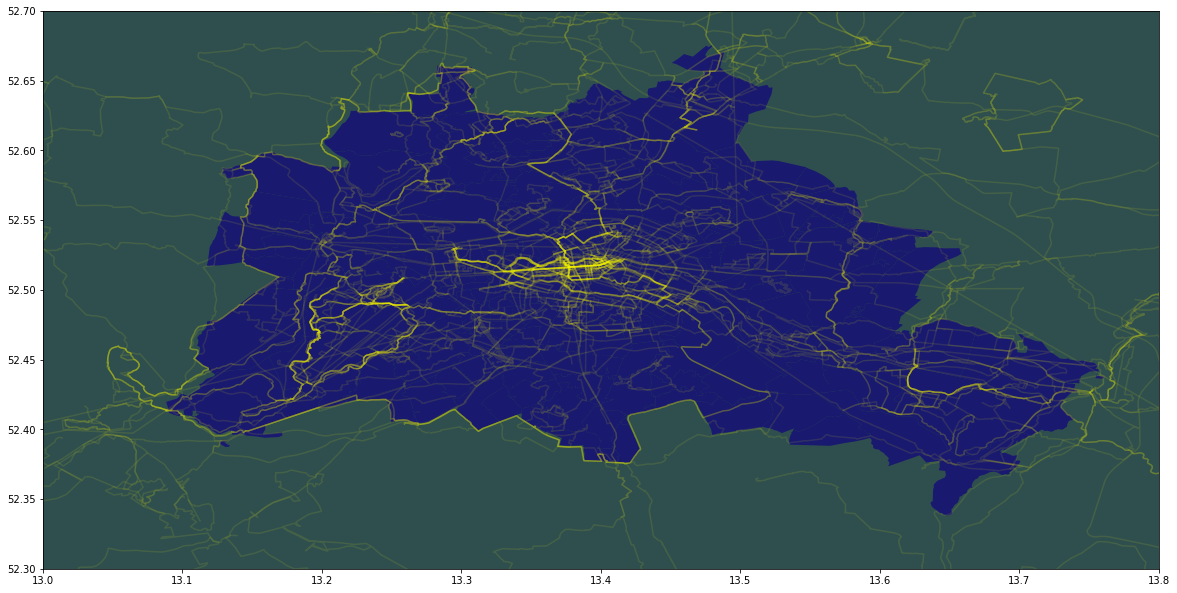

In [10]:
# Printing routes onto map of Berlin
fig, ax = plt.subplots(figsize=(20,12))
gdf_berlin.plot(ax=ax, color='midnightblue')
gdf_routesunique.plot(ax=ax, color='yellow', alpha=0.1)
ax.set_xlim(13.0, 13.8) # restricting the shown longitudes
ax.set_ylim(52.3, 52.7) # restricting the shown latitudes
ax.set_facecolor('darkslategrey') # setting background color

The geo plotting visualisation gives us intuitive insights on where our popular routes are located in Berlin. We can see clusters (thicker lines) near the touristic centres, Grunewald and Berliner Mauerweg.

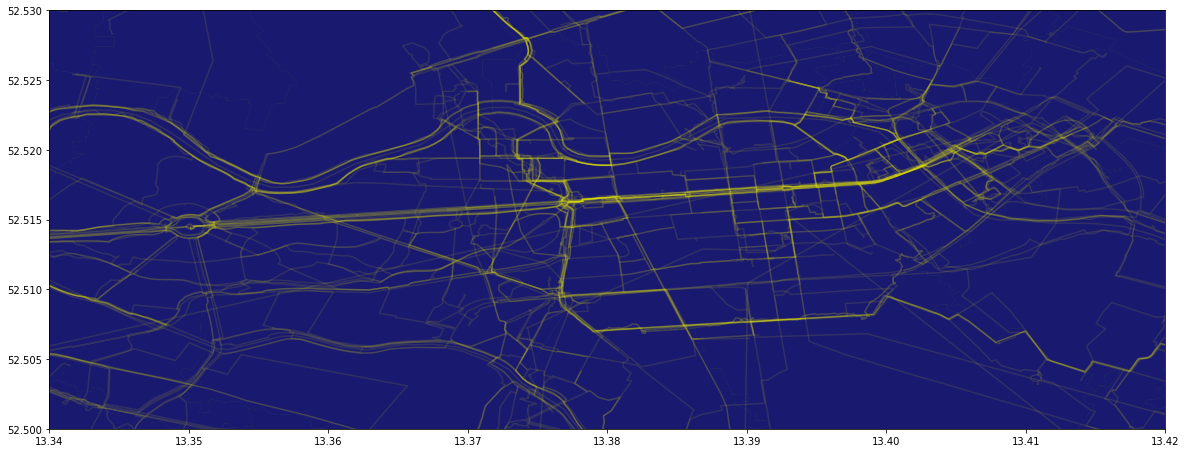

In [12]:
# Zooming in near Brandenburg Gate
fig, ax = plt.subplots(figsize=(20,8))
gdf_berlin.plot(ax=ax, color='midnightblue')
gdf_routesunique.plot(ax=ax, color='yellow', alpha=0.1)
ax.set_xlim(13.34, 13.42) # restricting the shown longitudes
ax.set_ylim(52.5, 52.53) # restricting the shown latitudes
ax.set_facecolor('darkslategrey') # setting background color

We can see that several routes pass along Unter den Linden and Straße des 17. Juni.

<font size="5"> Statistical Exploration </font>

The median amount of points of interest per route in our joint dataframe is: 62.0


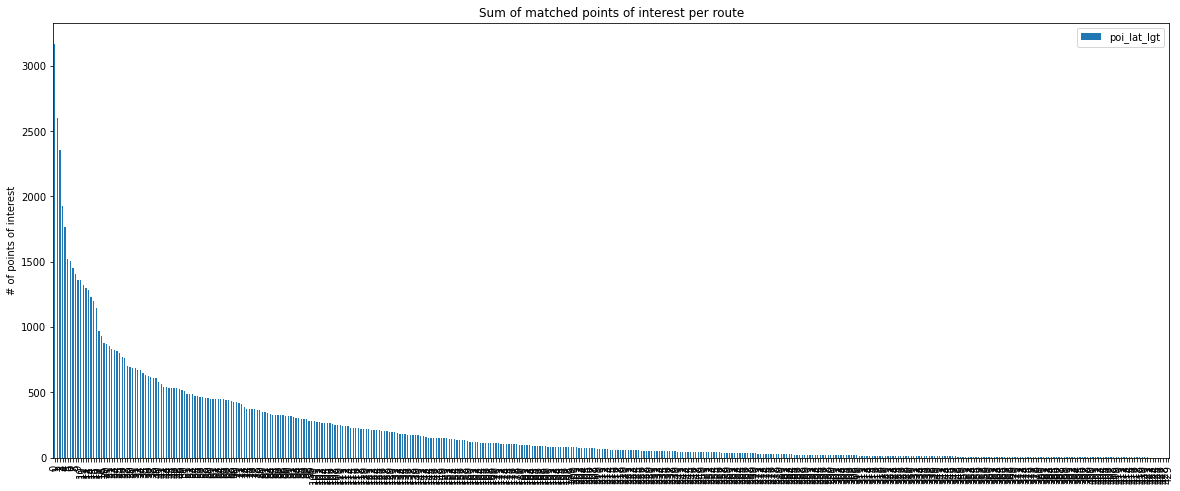

In [13]:
# Summarising the matching points of interest per each route
gdf_poiperroute = gdf_jointdata.groupby(by='route_id').agg({'poi_lat_lgt':'count'}).reset_index().sort_values(by='poi_lat_lgt', ascending=False)
barplot = gdf_poiperroute.plot.bar(
    x='route_id', 
    xlabel = 'routes', 
    ylabel = '# of points of interest', 
    title='Sum of matched points of interest per route', 
    use_index=False,
    figsize=(20,8)
    )
print('The median amount of points of interest per route in our joint dataframe is:', gdf_poiperroute['poi_lat_lgt'].median())

The plot confirms, that we're currently not having the best quality data! Only 430 routes had matched with our scraped points of interest (poi) to begin with and now we can see that half of them even pass by less than 62 points of interest.

Finding out about how categories are distributed within the routes

<AxesSubplot:title={'center':'Distributions of points of interest among all routes'}, ylabel='# of points of interest by category'>

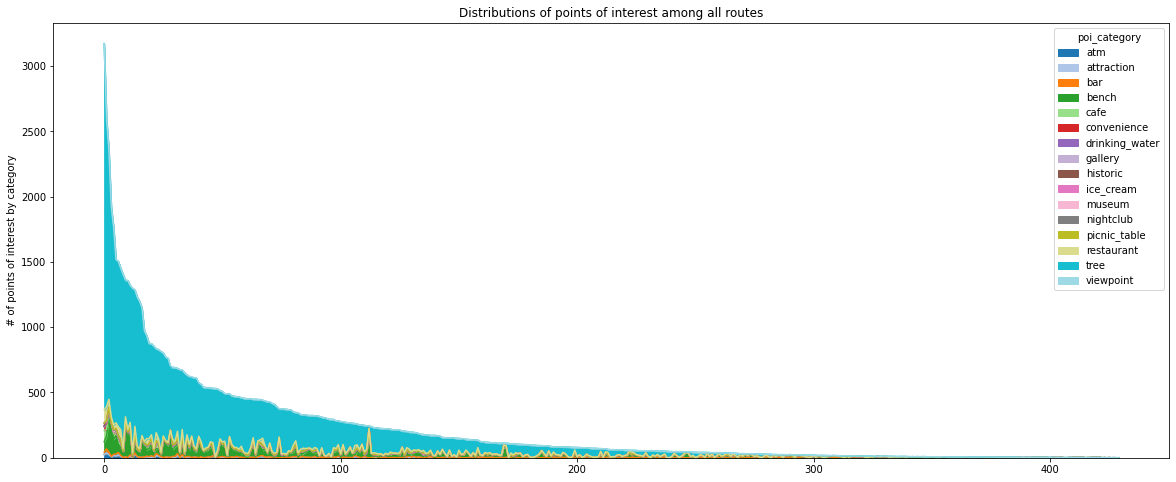

In [34]:
# Stacked bar plot to see the distributions of points of interest on all routes (absolute numbers)
columns_to_plot = ['atm', 'attraction', 'bar', 'bench', 'cafe', 'convenience', 'drinking_water', 'gallery', 'historic', 'ice_cream', 'museum', 'nightclub', 'picnic_table', 'restaurant', 'tree', 'viewpoint']
gdf_categoriesperroute = gdf_jointdata.groupby(by=['route_id', 'poi_category']).size().reset_index()
gdf_categoriesperroute.rename(columns={0:'count'}, inplace=True) 
gdf_categoriesperroute_wide = gdf_categoriesperroute.pivot(index='route_id', columns='poi_category', values="count")
gdf_categoriesperroute_wide['sum'] = gdf_categoriesperroute_wide.sum(axis=1, skipna=True) # new column with sum of poi per route
gdf_categoriesperroute_wide.sort_values(by='sum', ascending=False, inplace=True) # sorting by sum of poi per route
gdf_categoriesperroute_wide.plot.area(
    stacked=True,
    use_index=False,
    y = columns_to_plot,
    ylabel="# of points of interest by category",
    title="Distributions of points of interest among all routes",
    figsize=(20,8),
    colormap='tab20'
)

We can clearly see that longer routes ('longer' interpreted as higher number of waypoints) have more trees and more benches on it. Though, this graph doesn't show how points of interest (poi) are distributed percentage wise along the routes, which is probably more important for classifying them.

<AxesSubplot:title={'center':'Distributions of points of interest among all routes'}, ylabel='# of points of interest by category'>

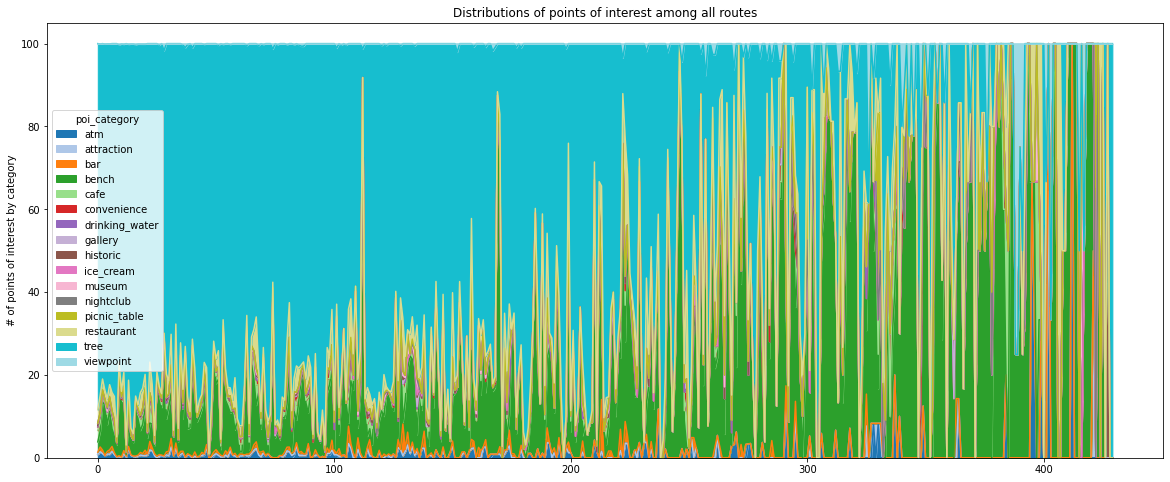

In [35]:
# Stacked bar plot to see the distributions of points of interest on all routes (percentages)
columns_to_plot = ['atm', 'attraction', 'bar', 'bench', 'cafe', 'convenience', 'drinking_water', 'gallery', 'historic', 'ice_cream', 'museum', 'nightclub', 'picnic_table', 'restaurant', 'tree', 'viewpoint']
gdf_categoriesperroute = gdf_jointdata.groupby(by=['route_id', 'poi_category']).size().reset_index()
gdf_categoriesperroute.rename(columns={0:'count'}, inplace=True) 
gdf_categoriesperroute_wide = gdf_categoriesperroute.pivot(index='route_id', columns='poi_category', values="count")
gdf_categoriesperroute_wide['sum'] = gdf_categoriesperroute_wide.sum(axis=1, skipna=True) # new column with sum of poi per route
gdf_categoriesperroute_wide.sort_values(by='sum', ascending=False, inplace=True) # sorting by sum of poi per route
gdf_categoriesperroute_wide = gdf_categoriesperroute_wide.apply(lambda x: 100 * x / gdf_categoriesperroute_wide['sum']) # percentages instead of absolute numbers
gdf_categoriesperroute_wide.plot.area(
    stacked=True,
    use_index=False,
    y = columns_to_plot,
    ylabel="# of points of interest by category",
    title="Distributions of points of interest among all routes",
    figsize=(20,8),
    colormap='tab20'
)

The normalised visualisation on the distribution of points of interest on all routes shows a pattern. Classification models will probably find different classes based on it. At first glance it seems that trees correlate negatively with benches.